In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [5]:
# timestep, Tmax, tolearnce for Newton's solver
h = 0.001
omega = 1
Tmax = 40.0
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# coefficients fo BDF2:
# u_{n+1} + alpha_0*u_n + alpha_1*u_{n-1} = h*beta_{-1}f_{n+1}
bm1 = (1+omega)/(1+2*omega)  # beta_{-1}
a0 = - (1 + omega)**2/(1+2*omega)  # alpha_0
a1 = omega**2/(1+2*omega)  # alpha_1

#coefficients in RHS of ODE
a = 0.04
b = 1.0e4
c = 3.0e7

# the right-hand side
def func(y): 
    
    dy = np.zeros(3)
    
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    
    return Jac

#initial conditions
y0 = np.array([1.0,0.0,0.0])

gamma = 1.0 - 1.0/np.sqrt(2)

def NewtonIterDIRK2_k1(y,h,k1):
    aux = y + h*gamma*k1
    F = k1 - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k1 - np.linalg.solve(DF,F)

def NewtonIterDIRK2_k2(y,h,k1,k2):
    aux = y + h*((1-gamma)*k1 + gamma*k2)
    F = k2 - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k2 - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2_k1(y,h,k1)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2_k2(y,h,k1,k2)
        aux = y + h*((1-gamma)*k1 + gamma*k2)
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux

def NewtonIterBDF(yn,yn1,h):
    
    F = yn - bm1*h*func(yn) + a0*yn + a1*yn1
    DF = np.identity(3) - bm1*h*Jac(yn)
    
    return yn - np.linalg.solve(DF,F)


def BDF2step(yn,yn1,h):
    
    for j in range(itermax):
        
        z = NewtonIterBDF(yn,yn1,h)
        aux = bm1*h*func(yn) - a0*yn - a1*yn1
        
        if np.linalg.norm(z - func(aux)) < tol:
            
            break
    
    return aux

In [11]:
sol = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol[0,:] = y0
sol[1,:] = DIRK2step(y0,h)

startBDF2 = time.time()

for j in range(1,Nsteps):
    sol[j+1,:] = BDF2step(sol[j,:],sol[j-1,:],h)
    
endBDF2 = time.time()
BDF2time = endBDF2 - startBDF2

sol2 = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol2[0,:] = y0
sol2[1,:] = DIRK2step(y0,h)

startDIRK2 = time.time()

for j in range(1,Nsteps):
    sol2[j+1,:] = DIRK2step(sol2[j,:],h)
    
endDIRK2 = time.time()
DIRK2time = endDIRK2 - startDIRK2

In [12]:
str('For BDF2 the CPU time is ') + str(BDF2time) + str(' seconds')

'For BDF2 the CPU time is 27.764816284179688 seconds'

In [13]:
str('For DIRK2 the CPU time is ') + str(DIRK2time) + str(' seconds')

'For DIRK2 the CPU time is 3.3733551502227783 seconds'

BDF2 is an implicit method, which means that it requires the solution of a system of nonlinear equations at each time step. In contrast, DIRK2 is a diagonally implicit method, which requires the solution of a system of linear equations at each time step. While both methods are suitable for stiff problems, the choice between them depends on the properties of the specific problem being solved.

In general, implicit methods like BDF2 tend to be more accurate and stable than explicit methods, but they can be more computationally expensive because of the need to solve nonlinear equations. For the Robertsen ODE, BDF2 may take longer to run than DIRK2 because the stiffness of the problem requires many time steps and the extra computational cost of the nonlinear solves in BDF2 can add up.

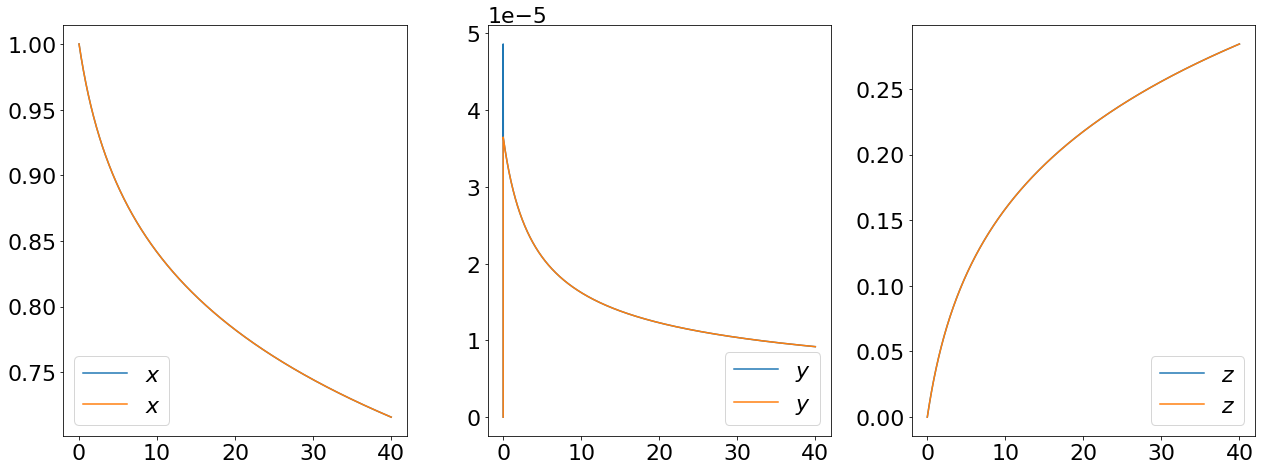

In [14]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,7))

ax1.plot( t, sol[:,0], label= r'$x$' ) 
ax1.plot( t, sol2[:,0], label= r'$x$' ) 
ax1.legend(loc = 'lower left')

ax2.plot( t, sol[:,1], label= r'$y$' ) 
ax2.plot( t, sol2[:,1], label= r'$y$' ) 
ax2.legend(loc = 'lower right')

ax3.plot( t, sol[:,2], label= r'$z$' ) 
ax3.plot( t, sol2[:,2], label= r'$z$' ) 
ax3.legend(loc = 'lower right')

plt.tight_layout()
plt.show()